### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12249
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     14.9| 30.4132| -86.6635|       PRCP|US1FLOK0014|    38|[00 00 00 00 B0 5...|2009.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     5|[40 5A F0 5A 80 5...|1999.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     3|[20 5B 78 5B 48 5...|2000.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    40|[90 55 E0 54 A0 5...|2001.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    12|[E0 54 30 54 30 5...|2002.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
print "no.of distinct stations : ", df.select('station').distinct().count()
df.select('station').distinct().show()
df.select('latitude').describe().show()
df.select('longitude').describe().show()

no.of distinct stations :  177
+-----------+
|    station|
+-----------+
|USW00063899|
|USC00013255|
|USC00013251|
|US1FLWT0002|
|USR0000FNAV|
|USC00228382|
|US1ALMB0018|
|US1ALMB0037|
|USC00081388|
|USW00003882|
|USC00012813|
|USW00003852|
|US1FLWS0001|
|USW00063869|
|US1FLES0005|
|USR0000ABNS|
|USC00012832|
|US1ALBW0041|
|US1FLOK0016|
|USC00086129|
+-----------+
only showing top 20 rows

+-------+-------------------+
|summary|           latitude|
+-------+-------------------+
|  count|              12249|
|   mean| 30.839723495795926|
| stddev|0.39577923163363876|
|    min|            30.0667|
|    max|            31.5253|
+-------+-------------------+

+-------+------------------+
|summary|         longitude|
+-------+------------------+
|  count|             12249|
|   mean|-87.08411093150343|
| stddev|0.8607260618392153|
|    min|             -88.5|
|    max|          -85.5824|
+-------+------------------+



### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' "%('TMAX')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show()
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
#scaling already taken care
#T=T/10.  # scaling to make the precipitation correct units
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' 
2020 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     5|[40 5A F0 5A 80 5...|1999.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     3|[20 5B 78 5B 48 5...|2000.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    40|[90 55 E0 54 A0 5...|2001.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    12|[E0 54 30 54 30 5...|2002.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    21|[38 59 40 5A 40 5...|2003.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     9|[00 7E 00 7E 00 7...|2004.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003

(2020, 365)

### Elevation Plots

In [4]:
def data_frame_for_measurement(meas,mx=True):
    sqlContext.registerDataFrameAsTable(df,'weather')
    Query="SELECT * FROM weather\n\tWHERE measurement='%s' "%(meas)
    print Query
    df1 = sqlContext.sql(Query)
    print df1.count(),'rows'
    #df1.show()
    if mx:
        rows_prcp=df1.rdd.map(lambda row:[np.nanmean(unpackArray(row['vector'],np.float16)), row['elevation'], row['latitude'], \
                            row['longitude'], row['station'], row['year'] ]).collect()
    else:
        rows_prcp=df1.rdd.map(lambda row:[np.max(unpackArray(row['vector'],np.float16)), row['elevation'], row['latitude'], \
                            row['longitude'], row['station'], row['year'] ]).collect()
    df_PRCP = pd.DataFrame(rows_prcp)
    #T=np.vstack(rows)
    #df_prcp = pd.DataFrame(rows_prcp)
    #scaling already taken care
    #T=T/10.  # scaling to make the precipitation correct units
    #shape(T)

    df_PRCP.columns=['Annual_Average','elevation','latitude','longitude','station','year']
    #df_PRCP.head()
    df_PRCP=df_PRCP[df_PRCP['elevation']>0]
    
    return(df_PRCP)

SELECT * FROM weather
	WHERE measurement='PRCP' 
2784 rows


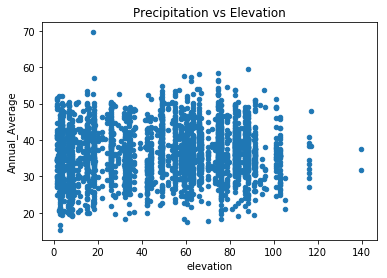

In [5]:
df_PRCP=data_frame_for_measurement('PRCP')
df_PRCP.plot.scatter(x='elevation',y='Annual_Average',title='Precipitation vs Elevation')
#df_PRCP[df_PRCP['elevation']<0]  #filter out these negative elevations
#df_PRCP

SELECT * FROM weather
	WHERE measurement='SNWD' 
1973 rows


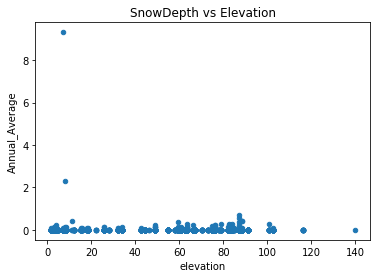

In [6]:
df_SNWD=data_frame_for_measurement('SNWD')
df_SNWD.plot.scatter(x='elevation',y='Annual_Average',title="SnowDepth vs Elevation")

SELECT * FROM weather
	WHERE measurement='SNOW' 
2107 rows


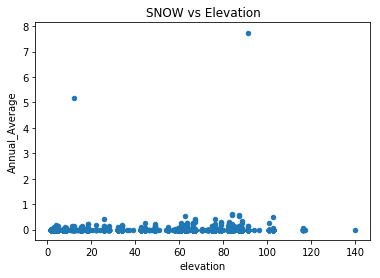

In [7]:
df_SNOW=data_frame_for_measurement('SNOW')
df_SNOW.plot.scatter(x='elevation',y='Annual_Average',title="SNOW vs Elevation")

SELECT * FROM weather
	WHERE measurement='TOBS' 
1344 rows


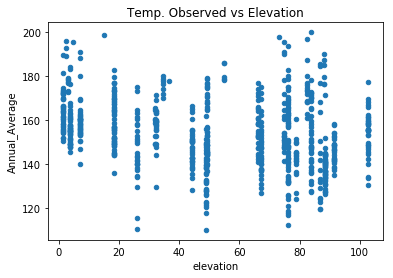

In [8]:
df_TOBS=data_frame_for_measurement('TOBS')
df_TOBS.plot.scatter(x='elevation',y='Annual_Average',title="Temp. Observed vs Elevation")

SELECT * FROM weather
	WHERE measurement='TMIN' 
2021 rows


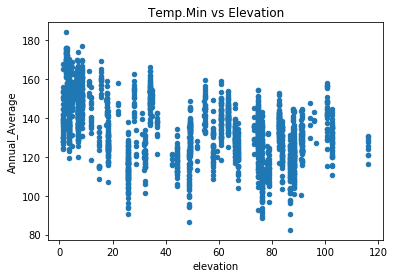

In [9]:
df_TMIN=data_frame_for_measurement('TMIN')
df_TMIN.plot.scatter(x='elevation',y='Annual_Average',title="Temp.Min vs Elevation")

SELECT * FROM weather
	WHERE measurement='TMAX' 
2020 rows


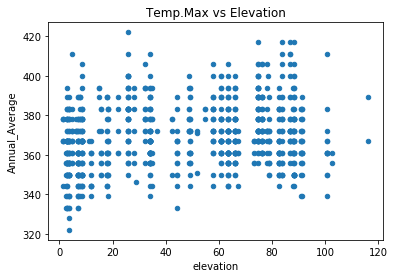

In [10]:
df_TMAX = data_frame_for_measurement('TMAX',mx=False)
df_TMAX.plot.scatter(x='elevation',y='Annual_Average',title="Temp.Max vs Elevation")
#df_TMAX

### Script for plotting yearly plots

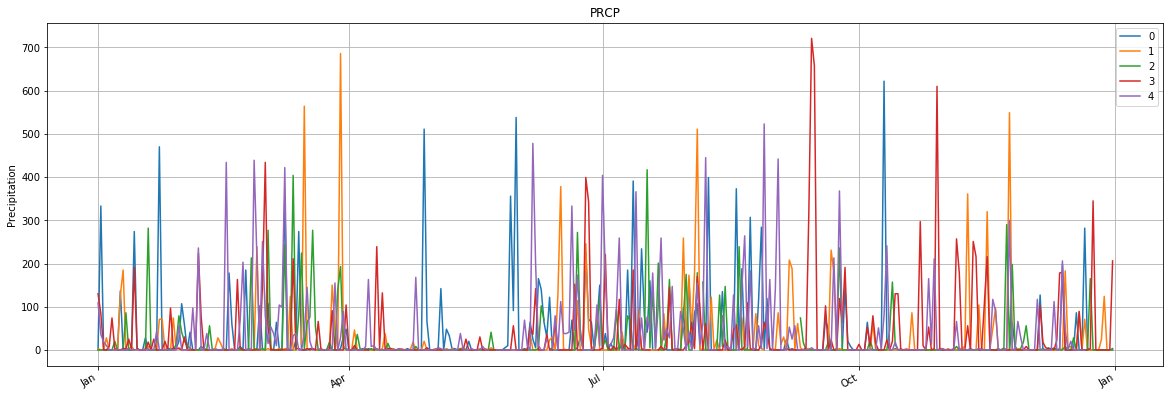

In [5]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(20,7));
plt.ylabel('Precipitation')
YP=YearPlotter()
YP.plot(T[:5,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [6]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    plt.ylabel('No. of Valid Entries in Data')
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


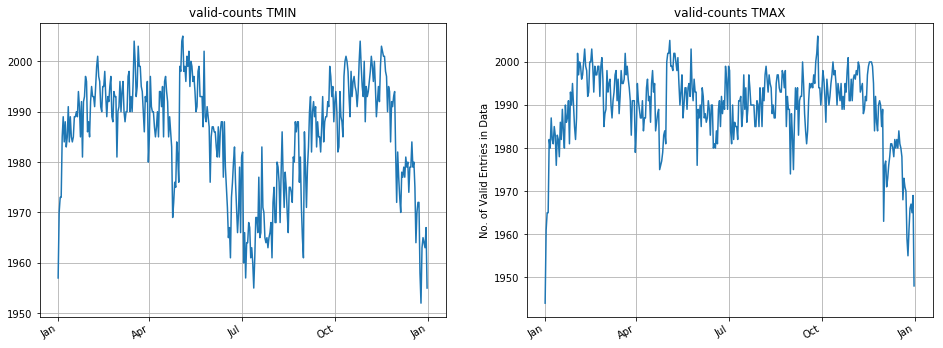

In [7]:
plot_pair(['TMIN','TMAX'],plot_valid)

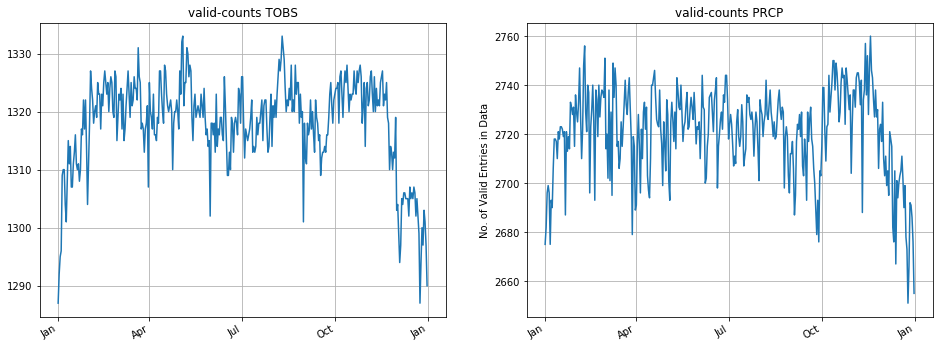

In [8]:
plot_pair(['TOBS','PRCP'],plot_valid)

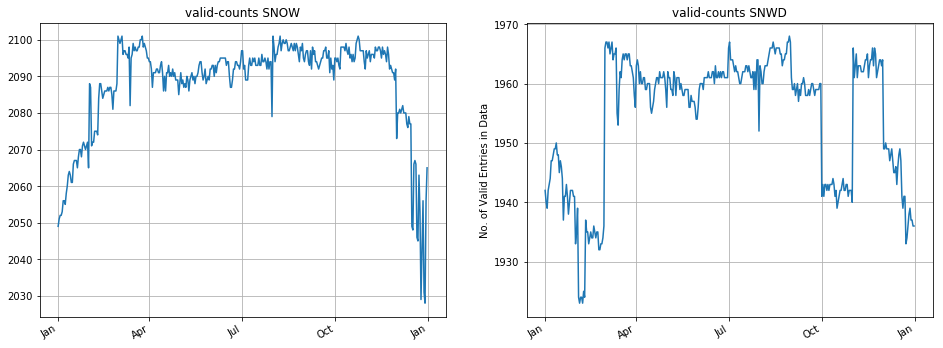

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [10]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    if m in ['TMIN','TMAX','TOBS']:
        axis.set_ylabel('Degrees Centigrade')
    else:
        axis.set_ylabel('Inches')

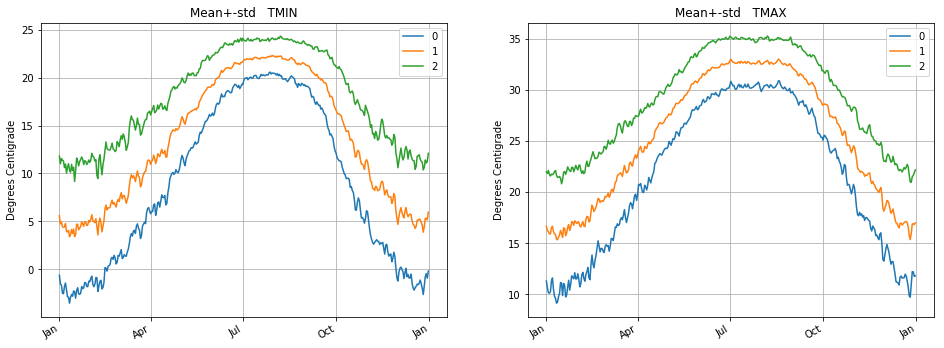

In [11]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

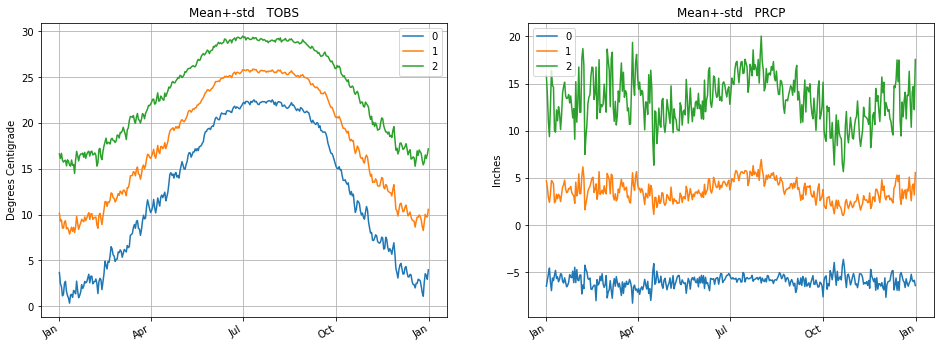

In [12]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

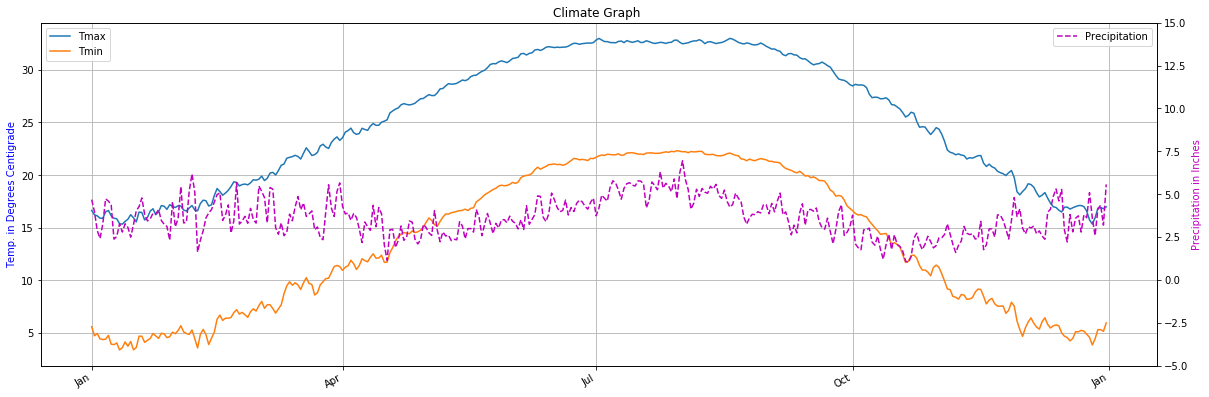

In [13]:
def plot_means(fig,axis,axis2):
    t_max_mean=STAT['TMAX']['Mean']
    t_min_mean=STAT['TMIN']['Mean']
    prcp_mean =STAT['PRCP']['Mean']
    #std=np.sqrt(STAT[m]['Var'])
    graphs =np.vstack([t_max_mean,t_min_mean]).transpose()
    graphs2=np.vstack([prcp_mean]).transpose()
    YP.plot_ax2(graphs,fig,axis,title='Climate Graph ',ax2=axis2,T1=graphs2,labels2=['Precipitation'],labels=['Tmax','Tmin'])
    axis.set_ylabel('Temp. in Degrees Centigrade',color='b')
    axis2.set_ylabel('Precipitation in Inches',color='m')

fig,ax1 = plt.subplots(figsize=(20,7))
ax2 = ax1.twinx()
plot_means(fig,ax1,ax2)


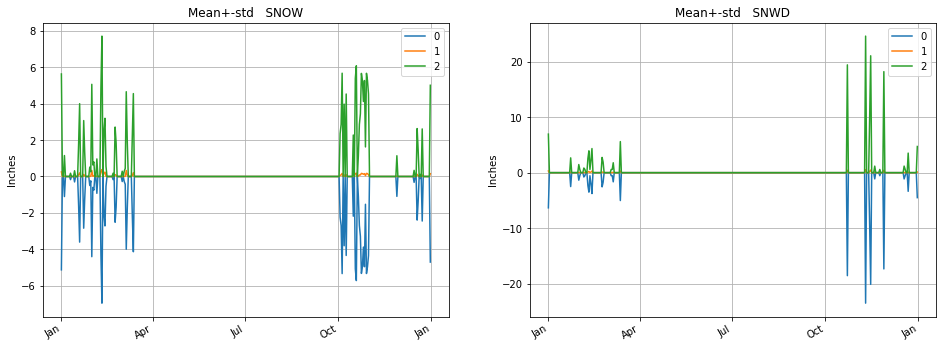

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [15]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

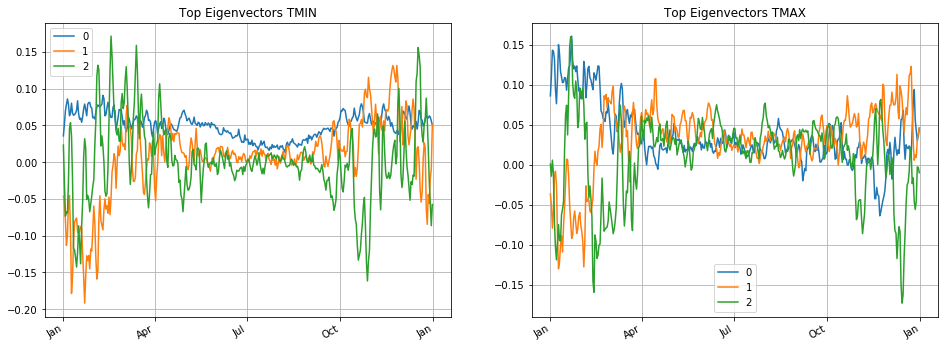

In [16]:
plot_pair(['TMIN','TMAX'],plot_eigen)

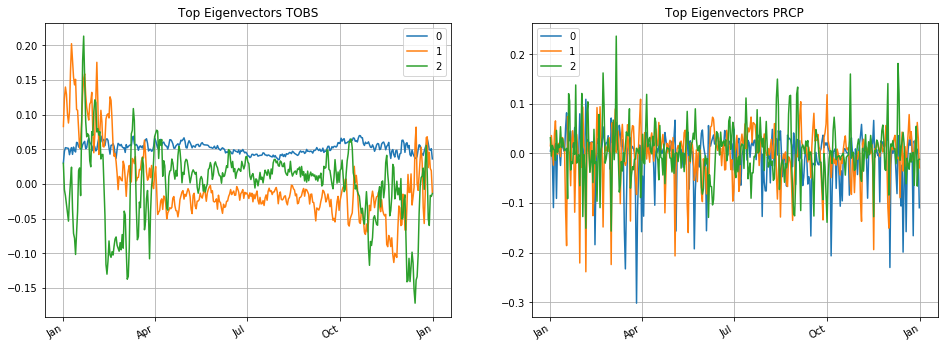

In [17]:
plot_pair(['TOBS','PRCP'],plot_eigen)

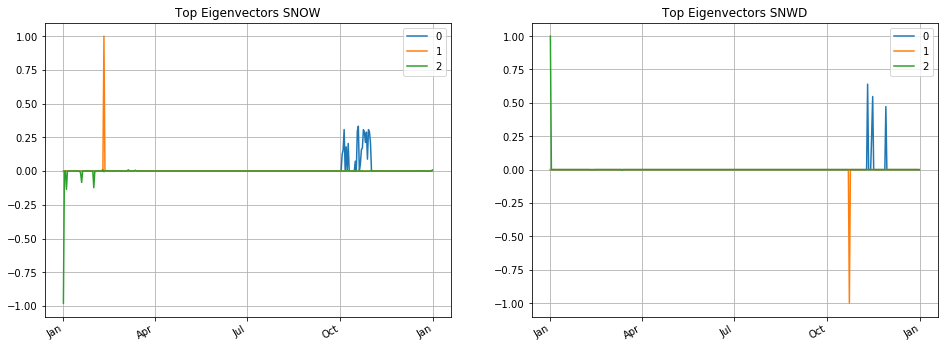

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [19]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=10
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

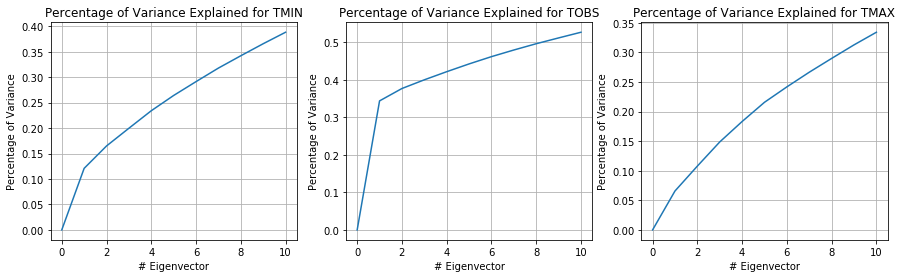

In [20]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

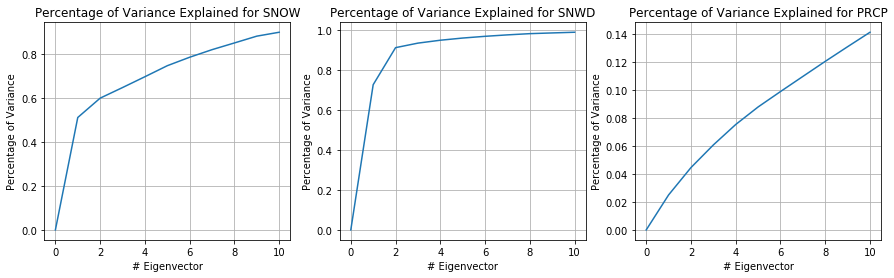

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [11]:
sc.stop()